In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os

def count_files_in_subfolders(root_dir):
    folder_file_counts = {}
    # Alt klasörlerde gezin
    for subfolder, _, files in os.walk(root_dir):
        # Alt klasör ismi ve içindeki dosya sayısını kaydet
        relative_path = os.path.relpath(subfolder, root_dir)  # Ana klasöre göre göreceli yol
        if relative_path == ".":
            continue  # Ana klasörün kendisini atla
        folder_file_counts[relative_path] = len(files)

    # Sonuçları yazdır
    for folder, file_count in folder_file_counts.items():
        print(f"Klasör: {folder}, Dosya Sayısı: {file_count}")

# Kullanım
root_directory = "/kaggle/working/dataset"
count_files_in_subfolders(root_directory)

Klasör: cardboard, Dosya Sayısı: 920
Klasör: trash, Dosya Sayısı: 920
Klasör: biological, Dosya Sayısı: 920
Klasör: paper, Dosya Sayısı: 920
Klasör: plastic, Dosya Sayısı: 920
Klasör: metal, Dosya Sayısı: 920
Klasör: clothes, Dosya Sayısı: 920
Klasör: shoes, Dosya Sayısı: 920
Klasör: glass, Dosya Sayısı: 920
Klasör: battery, Dosya Sayısı: 920


In [5]:
# Ayarlar
INPUT_PATH = "/kaggle/working/dataset"
OUTPUT_PATH = "/kaggle/working/split-dataset"
IMG_SIZE = (224, 224)
SAMPLES_PER_CLASS = 920
N_FOLDS = 5
BATCH_SIZE = 32
EPOCHS = 20

# ViT Transformer Code

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from datasets import Dataset, DatasetDict
from transformers import ViTImageProcessor
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from PIL import Image
import torch

In [ ]:
def load_images_and_labels(dataset_path):
    classes = os.listdir(dataset_path)
    images, labels = [], []
    class_to_idx = {cls: idx for idx, cls in enumerate(sorted(classes))}

    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(cls_path):
            images.append(os.path.join(cls_path, img_name))
            labels.append(class_to_idx[cls])

    return images, labels, class_to_idx

# Dataset preparation
dataset_path = "/kaggle/working/dataset"
images, labels, class_to_idx = load_images_and_labels(dataset_path)

# Feature extractor
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Image processing function
def preprocess_images(example):
    image = Image.open(example['image_path']).convert("RGB")
    example['pixel_values'] = feature_extractor(images=image, return_tensors="pt").pixel_values[0]
    return example

# K-Fold Cross Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

def create_dataset(images, labels):
    return Dataset.from_dict({'image_path': images, 'label': labels}).map(preprocess_images)

# Model and training
all_metrics = []
fold = 1
for train_index, val_index in skf.split(images, labels):
    print(f"Starting fold {fold}...")

    # Create train and validation datasets
    train_images = [images[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_images = [images[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = create_dataset(train_images, train_labels)
    val_dataset = create_dataset(val_images, val_labels)

    dataset = DatasetDict({"train": train_dataset, "validation": val_dataset})

    # Load pre-trained model with mismatched size handling
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224",
        num_labels=len(class_to_idx),
        id2label={i: label for label, i in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True  # Mismatched size hatasını görmezden gelir
    )

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir=f"./logs_fold_{fold}",
        logging_steps=10,  # Her 10 adımda bir log kaydı oluşturur
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to=["none"]  # WandB veya başka bir izleme aracı kullanmıyorsanız
    )

    # Compute metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=1)
        return {
            "accuracy": accuracy_score(labels, predictions),
            "precision": precision_score(labels, predictions, average='weighted'),
            "recall": recall_score(labels, predictions, average='weighted'),
            "f1": f1_score(labels, predictions, average='weighted'),
        }

    # Trainer
   # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    outputs = trainer.predict(dataset["validation"])
    preds = np.argmax(outputs.predictions, axis=1)
    metrics = {
        "fold": fold,
        "accuracy": accuracy_score(outputs.label_ids, preds),
        "precision": precision_score(outputs.label_ids, preds, average='weighted'),
        "recall": recall_score(outputs.label_ids, preds, average='weighted'),
        "f1": f1_score(outputs.label_ids, preds, average='weighted'),
        "confusion_matrix": confusion_matrix(outputs.label_ids, preds)
    }
    all_metrics.append(metrics)
    fold += 1

# Save results
results_df = pd.DataFrame([{k: v for k, v in m.items() if k != 'confusion_matrix'} for m in all_metrics])
results_df.to_csv("kfold_results.csv", index=False)

print("Training complete. Results:")
print(results_df)


In [8]:
# Modeli kaydetmek
model_save_path = f"/kaggle/working/vit_fold_{fold}_model"
tokenizer_save_path = f"/kaggle/working/vit_fold_{fold}_tokenizer"

# Modeli kaydet
model.save_pretrained(model_save_path)

# Tokenizer'ı kaydet
feature_extractor.save_pretrained(tokenizer_save_path)

print(f"Model ve tokenizer fold {fold} için kaydedildi.")


Model ve tokenizer fold 2 için kaydedildi.


# Swin Transformer Code

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from datasets import Dataset, DatasetDict
from transformers import AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer
from PIL import Image
import torch

def load_images_and_labels(dataset_path):
    classes = os.listdir(dataset_path)
    images, labels = [], []
    class_to_idx = {cls: idx for idx, cls in enumerate(sorted(classes))}

    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(cls_path):
            images.append(os.path.join(cls_path, img_name))
            labels.append(class_to_idx[cls])

    return images, labels, class_to_idx

# Dataset preparation
dataset_path = "/kaggle/working/dataset"
images, labels, class_to_idx = load_images_and_labels(dataset_path)

# Feature extractor
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Image processing function
def preprocess_images(example):
    image = Image.open(example['image_path']).convert("RGB")
    example['pixel_values'] = feature_extractor(images=image, return_tensors="pt").pixel_values[0]
    return example

# K-Fold Cross Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

def create_dataset(images, labels):
    return Dataset.from_dict({'image_path': images, 'label': labels}).map(preprocess_images)

# Model and training
all_metrics = []
confusion_matrices = []
fold = 1
for train_index, val_index in skf.split(images, labels):
    print(f"Starting fold {fold}...")

    # Create train and validation datasets
    train_images = [images[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_images = [images[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = create_dataset(train_images, train_labels)
    val_dataset = create_dataset(val_images, val_labels)

    dataset = DatasetDict({"train": train_dataset, "validation": val_dataset})

    # Load pre-trained model with mismatched size handling
    model = SwinForImageClassification.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(class_to_idx),
        id2label={i: label for label, i in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True  # Mismatched size hatasını görmezden gelir
    )

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir=f"./logs_fold_{fold}",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to=["none"]
    )

    # Compute metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=1)
        return {
            "accuracy": accuracy_score(labels, predictions),
            "precision": precision_score(labels, predictions, average='weighted'),
            "recall": recall_score(labels, predictions, average='weighted'),
            "f1": f1_score(labels, predictions, average='weighted'),
        }

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    outputs = trainer.predict(dataset["validation"])
    preds = np.argmax(outputs.predictions, axis=1)
    confusion_matrices.append(confusion_matrix(outputs.label_ids, preds))
    
    metrics = {
        "fold": fold,
        "accuracy": round(accuracy_score(outputs.label_ids, preds), 2),
        "precision": round(precision_score(outputs.label_ids, preds, average='weighted'), 2),
        "recall": round(recall_score(outputs.label_ids, preds, average='weighted'), 2),
        "f1": round(f1_score(outputs.label_ids, preds, average='weighted'), 2),
    }

    all_metrics.append(metrics)
    print(f"Fold {fold} metrics:")
    print(metrics)
    print("Confusion Matrix:")
    print(confusion_matrices[-1])

    fold += 1

    # Save the model
    model_save_path = f"/kaggle/working/saved_model_fold_{fold}"
    trainer.save_model(model_save_path)
    print(f"Model for fold {fold} saved at {model_save_path}")

# Combine confusion matrices and calculate averages
combined_confusion_matrix = sum(confusion_matrices)
averaged_metrics = {
    "accuracy": round(np.mean([m["accuracy"] for m in all_metrics]), 2),
    "precision": round(np.mean([m["precision"] for m in all_metrics]), 2),
    "recall": round(np.mean([m["recall"] for m in all_metrics]), 2),
    "f1": round(np.mean([m["f1"] for m in all_metrics]), 2),
}

print("\nCombined Confusion Matrix:")
print(combined_confusion_matrix)
print("\nAveraged Metrics:")
print(averaged_metrics)

# Save results
results_df = pd.DataFrame(all_metrics)
results_df.to_csv("kfold_results_swin.csv", index=False)

print("Training complete. Results saved.")


Starting fold 1...


Map:   0%|          | 0/7360 [00:00<?, ? examples/s]

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.326000,0.310338,0.908696,0.910104,0.908696,0.908283
2,0.135500,0.198307,0.936413,0.936518,0.936413,0.936191
3,0.150500,0.185838,0.941304,0.943332,0.941304,0.940800
4,0.068300,0.162742,0.948370,0.948885,0.948370,0.948177
5,0.056800,0.158220,0.951087,0.951400,0.951087,0.950892


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Fold 1 metrics:
{'fold': 1, 'accuracy': 0.95, 'precision': 0.95, 'recall': 0.95, 'f1': 0.95}
Confusion Matrix:
[[182   0   0   0   0   1   0   1   0   0]
 [  1 180   0   0   0   0   0   0   1   2]
 [  2   2 176   0   0   1   3   0   0   0]
 [  0   0   0 180   0   0   0   0   4   0]
 [  0   0   0   0 175   3   0   4   2   0]
 [  4   0   1   0   2 177   0   0   0   0]
 [  0   0  10   1   0   0 171   0   0   2]
 [  0   0   1   0   8   4   1 165   0   5]
 [  0   0   0   0   2   0   0   0 181   1]
 [  1   1   4   2   0   5   2   3   3 163]]
Model for fold 2 saved at /kaggle/working/saved_model_fold_2
Starting fold 2...


Map:   0%|          | 0/7360 [00:00<?, ? examples/s]

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.377300,0.294651,0.915217,0.916111,0.915217,0.914961
2,0.227600,0.206546,0.928261,0.929386,0.928261,0.928218
3,0.180500,0.182433,0.940217,0.940820,0.940217,0.939993
4,0.060200,0.168901,0.941304,0.941930,0.941304,0.941188
5,0.053500,0.164603,0.945109,0.945413,0.945109,0.944951


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Fold 2 metrics:
{'fold': 2, 'accuracy': 0.95, 'precision': 0.95, 'recall': 0.95, 'f1': 0.94}
Confusion Matrix:
[[180   1   0   0   1   2   0   0   0   0]
 [  0 179   0   0   0   1   2   1   0   1]
 [  1   0 178   0   0   0   4   0   0   1]
 [  0   0   0 181   0   0   2   0   1   0]
 [  1   4   0   0 166   6   1   6   0   0]
 [  2   0   1   0   1 175   4   1   0   0]
 [  0   0   6   0   0   0 175   0   0   3]
 [  0   0   4   0   8   4   1 161   1   5]
 [  0   1   0   0   0   1   1   0 180   1]
 [  2   0   2   0   3   4   3   4   2 164]]
Model for fold 3 saved at /kaggle/working/saved_model_fold_3
Starting fold 3...


Map:   0%|          | 0/7360 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # GPU 0 ve GPU 1'i kullan


In [ ]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [ ]:
tf.debugging.set_log_device_placement(True)


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


In [9]:
import torch
import torchvision.models as models

# Modeli tanımlayın (örneğin, Swin Transformer Tiny)
model = models.swin_t(pretrained=False)  # pretrained=False çünkü kendi modelinizi yüklüyorsunuz

# Modeli uygun cihaza taşıyın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Modelin durumunu yükleyin
checkpoint = torch.load("/kaggle/input/swin/pytorch/default/1/rng_state.pth", map_location=device)

# Eğer checkpoint bir dictionary ise ve 'model' anahtarını içeriyorsa, ağırlıkları bu anahtardan yükleyin
if isinstance(checkpoint, dict) and 'model' in checkpoint:
    model.load_state_dict(checkpoint['model'], strict=False)
else:
    # Aksi takdirde, doğrudan checkpoint'i yükleyin
    model.load_state_dict(checkpoint, strict=False)

model.eval()  # Değerlendirme moduna geçirin


<ipython-input-9-36d5331b11ab>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/swin/pytorch/default/1/rng_state.pth", map_location=d

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

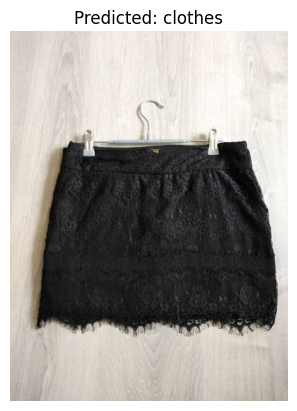

In [14]:
import os
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image

# Define the path to your dataset
dataset_path = "/kaggle/working/dataset"

# List all subdirectories (classes) in the dataset
classes = os.listdir(dataset_path)
class_name = random.choice(classes)  # Randomly select a class
class_path = os.path.join(dataset_path, class_name)

# List all images in the selected class
image_files = os.listdir(class_path)
image_file = random.choice(image_files)  # Randomly select an image
image_path = os.path.join(class_path, image_file)

# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
])

image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Perform inference
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

# Display the image and the predicted class
plt.imshow(image)
plt.title(f"Predicted: {class_name}")
plt.axis('off')
plt.show()


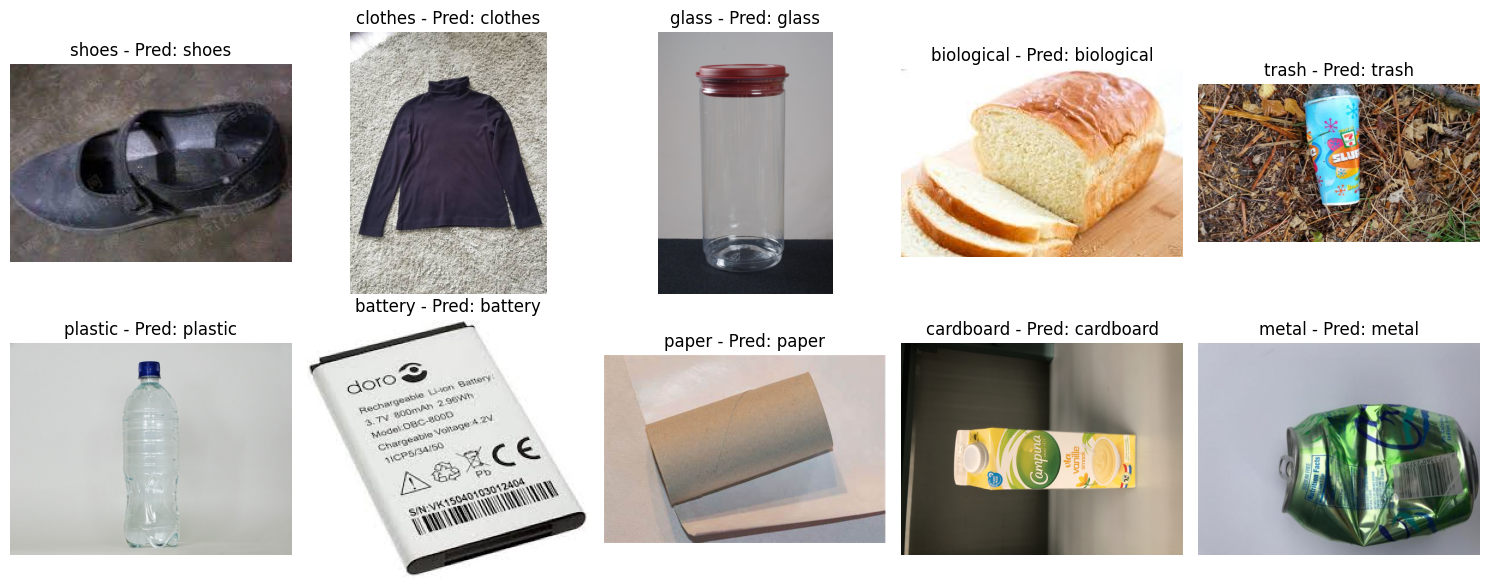

In [15]:
import os
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image

# Define the path to your dataset
dataset_path = "/kaggle/working/dataset"

# List all subdirectories (classes) in the dataset
classes = os.listdir(dataset_path)

# Select 10 random classes
sampled_classes = random.sample(classes, 10)

# Set up the figure to display images in a grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns
axes = axes.flatten()

# Transformation to preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
])

# Loop through the selected classes and display one image from each
for i, class_name in enumerate(sampled_classes):
    class_path = os.path.join(dataset_path, class_name)
    
    # List all images in the selected class
    image_files = os.listdir(class_path)
    image_file = random.choice(image_files)  # Randomly select an image
    image_path = os.path.join(class_path, image_file)

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    # Display the image with predicted class label
    axes[i].imshow(image)
    axes[i].set_title(f"{class_name} - Pred: {class_name}")  # You can modify this to show predicted label
    axes[i].axis('off')

# Show the grid of images
plt.tight_layout()
plt.show()
